# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='https://github.com/udacity/pytorch_challenge/blob/master/assets/Flowers.png?raw=1' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [0]:
# google colab does not come with torch installed. And also, in course we are using torch 0.4. 
# so following snippet of code installs the relevant version

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [137]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [138]:
# we need pillow version of 5.3.0
# we will uninstall the older version first
!pip uninstall -y Pillow
# install the new one
!pip install Pillow==5.3.0
# import the new one
import PIL
print(PIL.PILLOW_VERSION)
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
5.3.0


In [139]:
!wget -c https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py


--2019-01-04 09:36:06--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [0]:
# This is the contents of helper.py 
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable


def test_network(net, trainloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # Create Variables for the inputs and targets
    inputs = Variable(images)
    targets = Variable(images)

    # Clear the gradients from all Variables
    optimizer.zero_grad()

    # Forward pass, then backward pass, then update weights
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True


def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax
def view_recon(img, recon):
    ''' Function for displaying an image (as a PyTorch Tensor) and its
        reconstruction also a PyTorch Tensor
    '''

    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
    axes[0].imshow(img.numpy().squeeze())
    axes[1].imshow(recon.data.numpy().squeeze())
    for ax in axes:
        ax.axis('off')
        ax.set_adjustable('box-forced')  

In [0]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets , transforms , models

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
# we will download the required data files
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!rm -r flower_data || true
!unzip -qq flower_data.zip

In [0]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [0]:
# TODO: Define your transforms for the training and validation sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),transforms.RandomResizedCrop(224),transforms.RandomHorizontalFlip(),transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir , transform=train_transforms)
test_data = datasets.ImageFolder(valid_dir, transform=test_transforms)



# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [146]:
#mounting the model to drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
model_save_name = 'classifier.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [0]:
from torch.optim import lr_scheduler
# TODO: Build and train your network

# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#using pre-trained resnet50 from imageNet database
model = models.resnet152(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

#creating our own classifier with name fc (as defined in resnet50)
model.fc = nn.Sequential(nn.Linear(2048, 512),nn.ReLU(),nn.Linear(512,102),nn.LogSoftmax(dim=1))    

#using crossentropyloss
criterion = nn.NLLLoss()

#taking steps of gradient descent with lr =0.01 and only fc parameters ,Only train the classifier parameters, feature parameters are frozen

optimizer = torch.optim.Adam(model.fc.parameters() , lr = 0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)


model.to(device);

In [0]:
#train the model
epochs = 20

#to have a history of losses to plot the graph
train_losses , test_losses = [] , []

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf #set initial "min" to infinity
#to put the model in training mode
model.train()
for epoch in range(epochs):
  running_loss = 0
  scheduler.step()
  for images , labels in trainloader:
    images, labels = images.to(device), labels.to(device)
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    #forward pass (feed forward)forward pass: compute predicted outputs by passing inputs to the model
    outputs = model(images)
    # calculate the loss
    loss = criterion(outputs,labels)
    #gradient descent ,backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    # perform a single optimization step (parameter update)
    optimizer.step()
    # update running training loss
    running_loss += loss.item()
  # initialize lists to monitor test loss and accuracy
  test_loss = 0
  accuracy = 0
  #we no longer gradients to be calculated
  with torch.no_grad():
    model.eval() # prep model for evaluation
    for images , labels in testloader:
      images, labels = images.to(device), labels.to(device)
      logps = model(images) # forward pass: compute predicted outputs by passing inputs to the model
      test_loss += criterion(logps,labels) #calculate the loss and update the loss
      ps = torch.exp(logps)
      top_p , top_class = ps.topk(1,dim=1)
      equals = top_class == labels.view(*top_class.shape)
      accuracy += torch.mean(equals.type(torch.FloatTensor))    
   
  train_losses.append(running_loss/len(trainloader))
  test_losses.append(test_loss/len(testloader))
  print("Epoch: {}/{}.. ".format(epoch+1, epochs),"Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),"Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
        "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
  model.train() 
  # save model if validation loss has decreased
  if test_loss/len(testloader) <= valid_loss_min:
        print('test loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,test_loss/len(testloader))) 
        torch.save(model.state_dict(), path)
        valid_loss_min = test_loss/len(testloader)  

Epoch: 1/20..  Training Loss: 2.762..  Test Loss: 1.161..  Test Accuracy: 0.714
test loss decreased (inf --> 1.161488).  Saving model ...
Epoch: 2/20..  Training Loss: 1.042..  Test Loss: 0.557..  Test Accuracy: 0.875
test loss decreased (1.161488 --> 0.557300).  Saving model ...
Epoch: 3/20..  Training Loss: 0.724..  Test Loss: 0.391..  Test Accuracy: 0.903
test loss decreased (0.557300 --> 0.390849).  Saving model ...
Epoch: 4/20..  Training Loss: 0.587..  Test Loss: 0.354..  Test Accuracy: 0.901
test loss decreased (0.390849 --> 0.354165).  Saving model ...
Epoch: 5/20..  Training Loss: 0.497..  Test Loss: 0.313..  Test Accuracy: 0.923
test loss decreased (0.354165 --> 0.312529).  Saving model ...
Epoch: 6/20..  Training Loss: 0.469..  Test Loss: 0.302..  Test Accuracy: 0.920
test loss decreased (0.312529 --> 0.302491).  Saving model ...
Epoch: 7/20..  Training Loss: 0.480..  Test Loss: 0.338..  Test Accuracy: 0.905
Epoch: 8/20..  Training Loss: 0.406..  Test Loss: 0.244..  Test Acc

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

This is not actual saving part rather than saving at the end we save after every epoch when validation loss decreases and hence can have model with best accuracy.

In [0]:
# TODO: Save the checkpoint 
model.class_to_idx = train_data.class_to_idx



## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
model.load_state_dict(torch.load(path))


In [149]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
from PIL import Image
image_path = 'flower_data/valid/28/image_05258.jpg'
img = Image.open(image_path)
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

<class 'numpy.ndarray'>


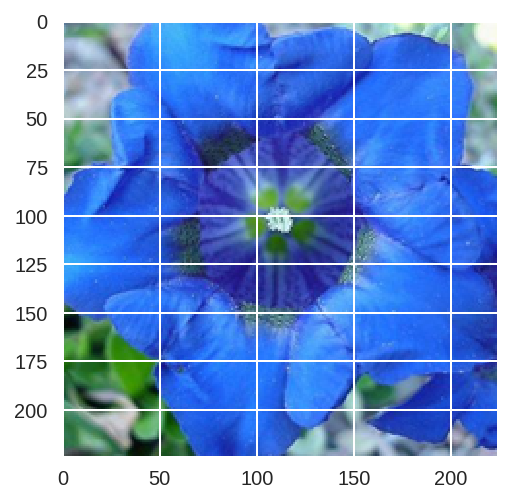

In [154]:
img = process_image(image_path)
print(type(img))
imshow(img)


## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='https://github.com/udacity/pytorch_challenge/blob/master/assets/inference_example.png?raw=1' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
def predict(image_path, model, top_k=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    
    image_path: string. Path to image, directly to image and not to folder.
    model: pytorch neural network.
    top_k: integer. The top K classes to be calculated
    
    returns top_probabilities(k), top_labels
    '''
    
    # No need for GPU on this part (just causes problems)
    model.to("cpu")
    
    # Set model to evaluate
    model.eval();

    # Convert image from numpy to torch
    torch_image = torch.from_numpy(np.expand_dims(process_image(image_path), 
                                                  axis=0)).type(torch.FloatTensor).to("cpu")

    # Find probabilities (results) by passing through the function (note the log softmax means that its on a log scale)
    log_probs = model.forward(torch_image)

    # Convert to linear scale
    linear_probs = torch.exp(log_probs)

    # Find the top 5 results
    top_probs, top_labels = linear_probs.topk(top_k)
    
    # Detatch all of the details
    top_probs = np.array(top_probs.detach())[0] # This is not the correct way to do it but the correct way isnt working thanks to cpu/gpu issues so I don't care.
    top_labels = np.array(top_labels.detach())[0]
    
    # Convert to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labels]
    top_flowers = [cat_to_name[lab] for lab in top_labels]
    
    return top_probs, top_labels, top_flowers

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


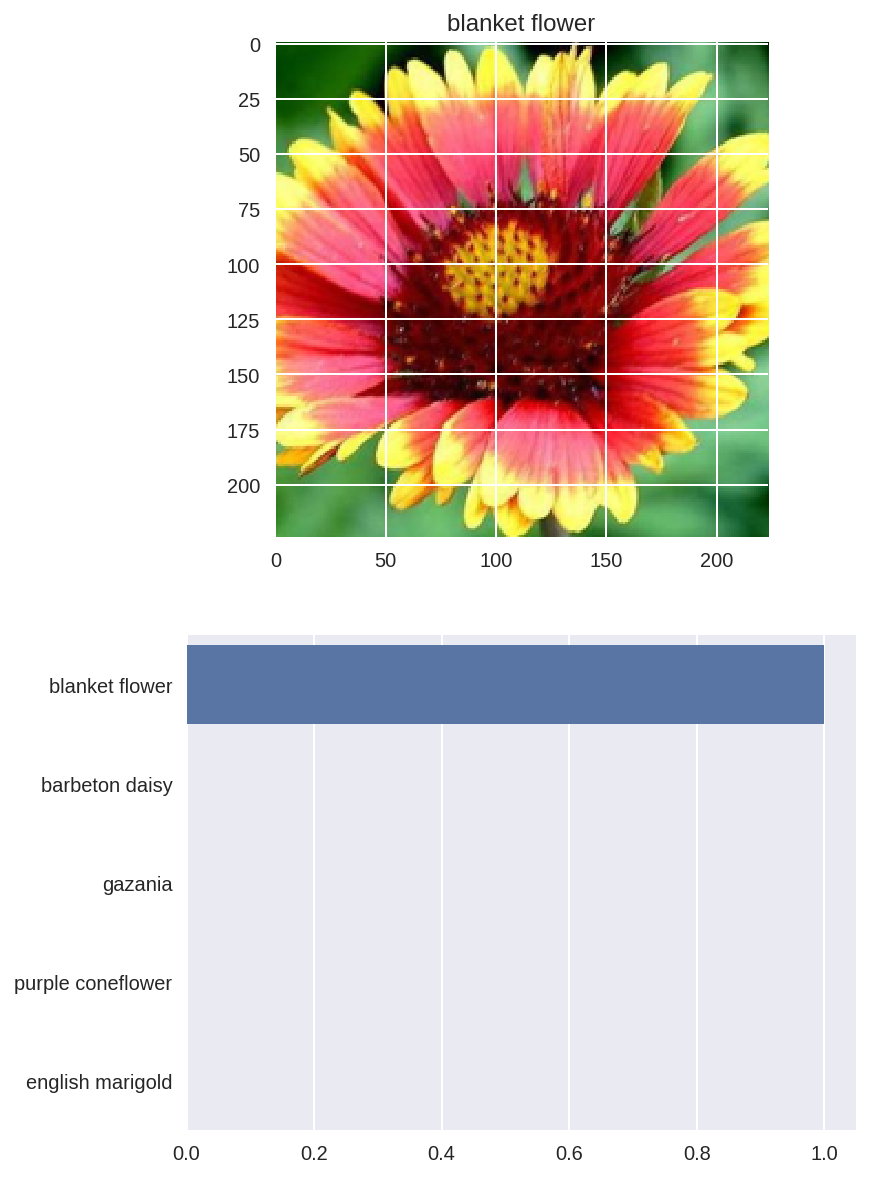

In [174]:
import seaborn as sns
# TODO: Display an image along with the top 5 classes
# Define image path
image_path = "flower_data/valid/100/image_07895.jpg"

# Set up plot
plt.figure(figsize = (6,10))
ax = plt.subplot(2,1,1)

# Set up title
flower_num = image_path.split('/')[2]
title_ = cat_to_name[flower_num]

# Plot flower
img = process_image(image_path)
imshow(img, ax, title = title_);

# Make prediction
probs, labs, flowers = predict(image_path, model) 

# Plot bar chart
plt.subplot(2,1,2)
sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
plt.show()

#THIS IS MODIFIED FROM NOW ONWARDS


In [171]:
print(cat_to_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's